# Simulate an open field environment

+ Place field size: 1775 cm**2 (~42 cm)
+ Replay speed: 1920 cm/s
   - ~2 cm/ms

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


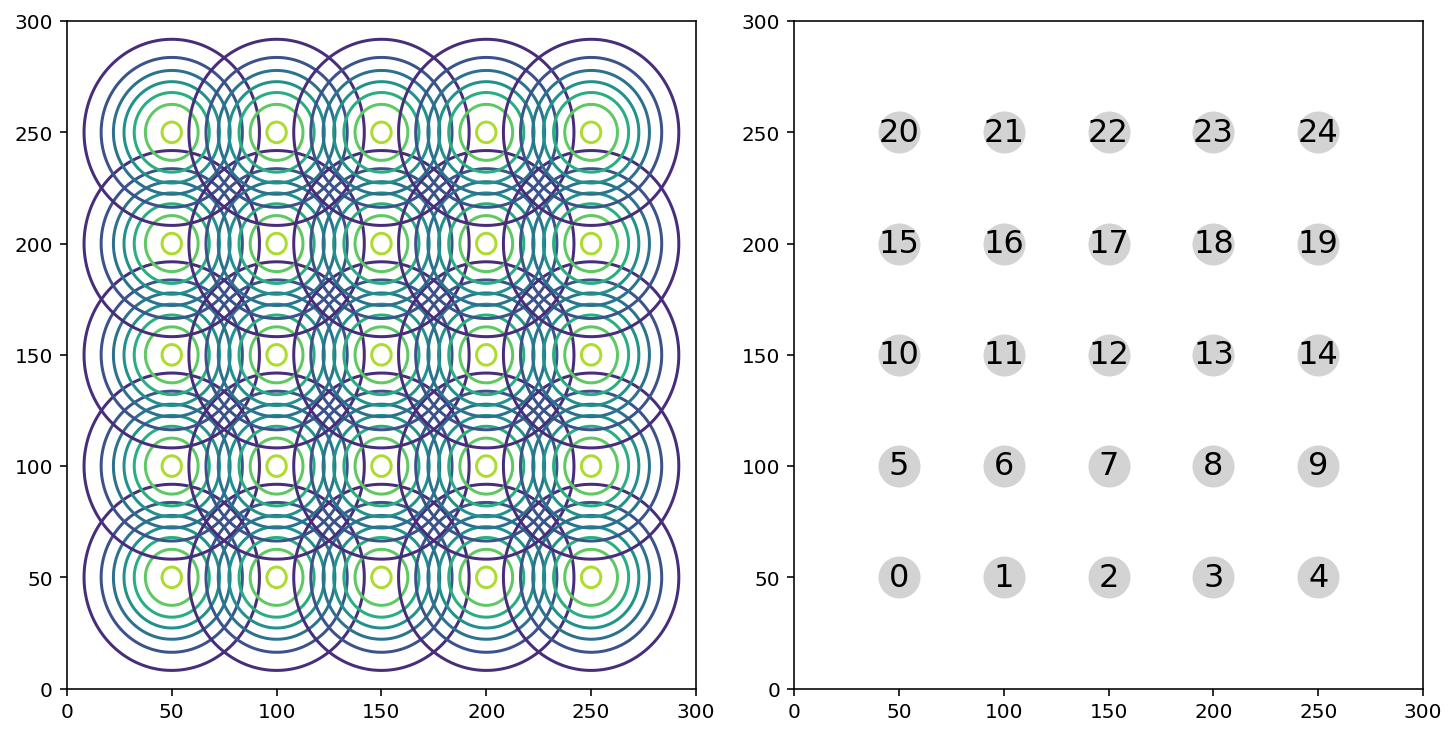

In [3]:
from scipy.stats import multivariate_normal
from replay_trajectory_classification.simulate import \
    simulate_neuron_with_place_field
from src.parameters import SAMPLING_FREQUENCY

PLACE_FIELD_SIZE = 1775
PLACE_FIELD_SPACING = 50
TRACK_LENGTH = 300

center_x = np.arange(50, 300, PLACE_FIELD_SPACING)
center_y = np.arange(50, 300, PLACE_FIELD_SPACING)
center_x, center_y = np.meshgrid(center_x, center_y)
place_field_centers = np.stack((center_x.ravel(), center_y.ravel()), axis=1)

x = np.linspace(0, TRACK_LENGTH, TRACK_LENGTH)
y = np.linspace(0, TRACK_LENGTH, TRACK_LENGTH)

x, y = np.meshgrid(x, y)
position_grid = np.stack((x.ravel(), y.ravel()), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for center in place_field_centers:
    rate = multivariate_normal(mean=center, cov=(np.sqrt(PLACE_FIELD_SIZE) / 2)**2).pdf(position_grid)
    axes[0].contour(x, y, rate.reshape(x.shape));

axes[0].set_xlim((0, TRACK_LENGTH))
axes[0].set_ylim((0, TRACK_LENGTH))

for ind, center in enumerate(place_field_centers):
    axes[1].scatter(center[0], center[1], color='lightgrey', s=400)
    axes[1].text(center[0], center[1], ind, fontsize=16, ha='center', va='center')
    
axes[1].set_xlim((0, TRACK_LENGTH))
axes[1].set_ylim((0, TRACK_LENGTH));

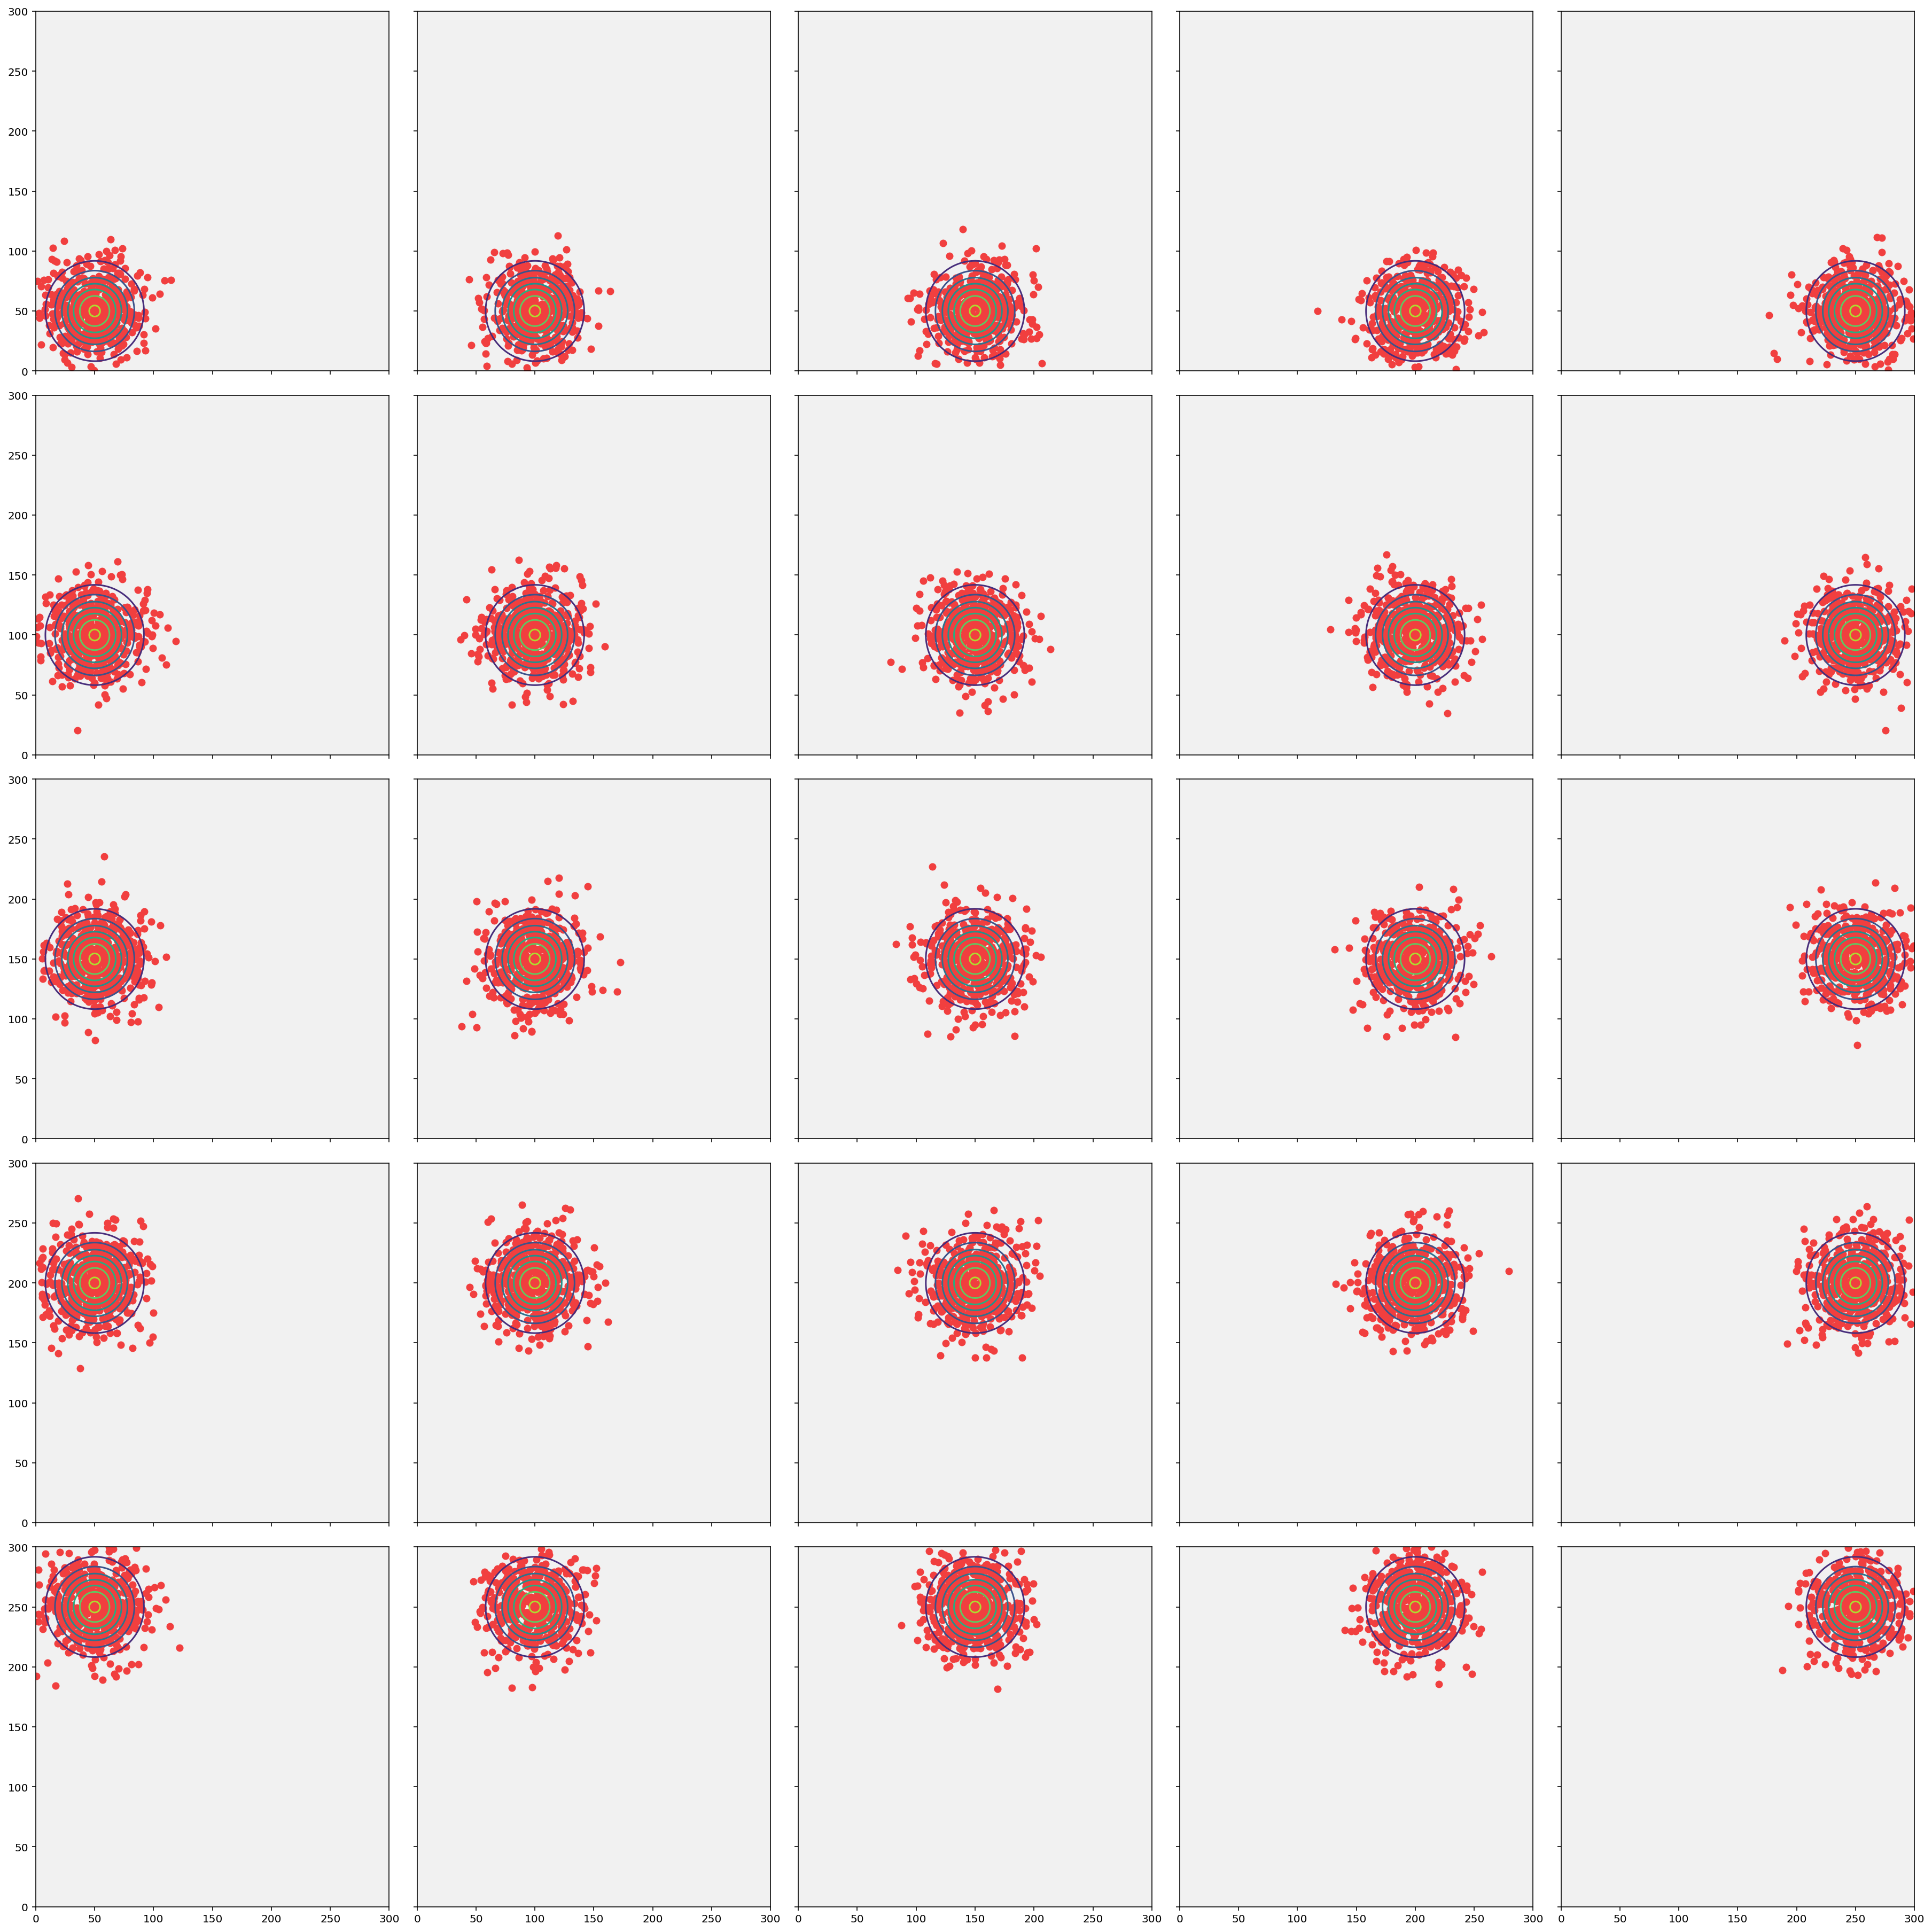

In [25]:
x_pos = np.arange(0, TRACK_LENGTH, 0.5)
y_pos = np.arange(0, TRACK_LENGTH, 0.5)

x_pos, y_pos = np.meshgrid(x_pos, y_pos)
position = np.stack((x_pos.ravel(), y_pos.ravel()), axis=1).astype(np.float)
position = np.concatenate((position, position, position), axis=0)
position += multivariate_normal(mean=(0, 0), cov=np.sqrt(0.5)).rvs(position.shape[0])
position = np.clip(position, 0, TRACK_LENGTH)

spikes = np.stack(
    [simulate_neuron_with_place_field(
        center, position, max_rate=15, variance=(np.sqrt(PLACE_FIELD_SIZE) / 2)**2,
        sampling_frequency=SAMPLING_FREQUENCY)
     for center in place_field_centers], axis=1)

fig, axes = plt.subplots(5, 5, figsize=(25, 25),
                         constrained_layout=True, sharex=True, sharey=True)

if spikes is not None and position is not None:
    spikes, position = np.asarray(spikes), np.asarray(position)
    for ax, is_spike, center in zip(axes.flat, spikes.T, place_field_centers):
        is_spike = is_spike > 0
        ax.plot(position[:, 0], position[:, 1], color='lightgrey',
                alpha=0.3, zorder=1)
        rate = multivariate_normal(mean=center, cov=(np.sqrt(PLACE_FIELD_SIZE) / 2)**2).pdf(position_grid)
        ax.contour(x, y, rate.reshape(x.shape))
        ax.scatter(position[is_spike, 0], position[is_spike, 1],
                   color='red', zorder=1)
    
ax.set_xlim((0, TRACK_LENGTH))
ax.set_ylim((0, TRACK_LENGTH));

In [ ]:
from dask.distributed import Client, LocalCluster

client = Client(processes=False)

In [ ]:
from replay_trajectory_classification import SortedSpikesClassifier

continuous_transition_types = ['random_walk2', 'uniform', 'identity']

classifier = SortedSpikesClassifier(
        movement_var=(np.sqrt(1) / 2) ** 2, replay_speed=2, knot_spacing=np.sqrt(PLACE_FIELD_SIZE) / 2,
        place_bin_size=2.0, continuous_transition_types=continuous_transition_types,
        discrete_transition_diag=1-1e-3
).fit(position, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


In [ ]:
g = classifier.plot_place_fields(spikes, position, SAMPLING_FREQUENCY)

In [5]:
from src.simulation import _get_euclidean_dist

def continuous_replay(place_field_centers, replay_speed=2000.0):
    neuron_ind = np.asarray([0, 6, 12, 18, 24])

    dist = _get_euclidean_dist(place_field_centers[neuron_ind])

    spike_time_ind = np.cumsum(
        np.insert(np.ceil(SAMPLING_FREQUENCY * dist / replay_speed), 0, 1)
    ).astype(np.int)

    n_neurons = place_field_centers.shape[0]
    n_time = int(spike_time_ind.max() + 1)
    time = np.arange(n_time) / SAMPLING_FREQUENCY
    test_spikes = np.zeros((n_time, n_neurons))
    test_spikes[(spike_time_ind, neuron_ind)] = 1.0

    return test_spikes, time

test_spikes, time = continuous_replay(place_field_centers)

time[np.nonzero(test_spikes)[0]], np.nonzero(test_spikes)[1]

(array([0.001, 0.037, 0.073, 0.109, 0.145]), array([ 0,  6, 12, 18, 24]))

In [6]:
def hover_replay(place_field_centers, replay_speed=2000.0):
    
    test_spikes, time = continuous_replay(place_field_centers, replay_speed)

    spike_time_ind = np.nonzero(test_spikes)[0]
    neuron_ind = np.asarray([12, 12, 12, 12, 12])

    n_neurons = place_field_centers.shape[0]
    n_time = int(spike_time_ind.max() + 1)
    test_spikes = np.zeros((n_time, n_neurons))
    test_spikes[(spike_time_ind, neuron_ind)] = 1.0

    return test_spikes, time

test_spikes, time = hover_replay(place_field_centers)
time[np.nonzero(test_spikes)[0]], np.nonzero(test_spikes)[1]

(array([0.001, 0.037, 0.073, 0.109, 0.145]), array([12, 12, 12, 12, 12]))

In [7]:
def fragmented_replay1(place_field_centers):
    neuron_ind = np.asarray([0, 20, 24, 4, 12])
    spike_time_ind = np.arange(0, neuron_ind.size * 2, 2)

    n_neurons = place_field_centers.shape[0]
    n_time = int(spike_time_ind.max() + 1)
    test_spikes = np.zeros((n_time, n_neurons))
    test_spikes[(spike_time_ind, neuron_ind)] = 1.0

    return test_spikes, time

test_spikes, time = fragmented_replay1(place_field_centers)
time[np.nonzero(test_spikes)[0]], np.nonzero(test_spikes)[1]

(array([0.   , 0.002, 0.004, 0.006, 0.008]), array([ 0, 20, 24,  4, 12]))

In [8]:
def fragmented_replay2(place_field_centers, replay_speed=2000.0):
    
    test_spikes, time = continuous_replay(place_field_centers, 10 * replay_speed)

    return test_spikes, time

test_spikes, time = fragmented_replay2(place_field_centers)
time[np.nonzero(test_spikes)[0]], np.nonzero(test_spikes)[1]

(array([0.001, 0.005, 0.009, 0.013, 0.017]), array([ 0,  6, 12, 18, 24]))

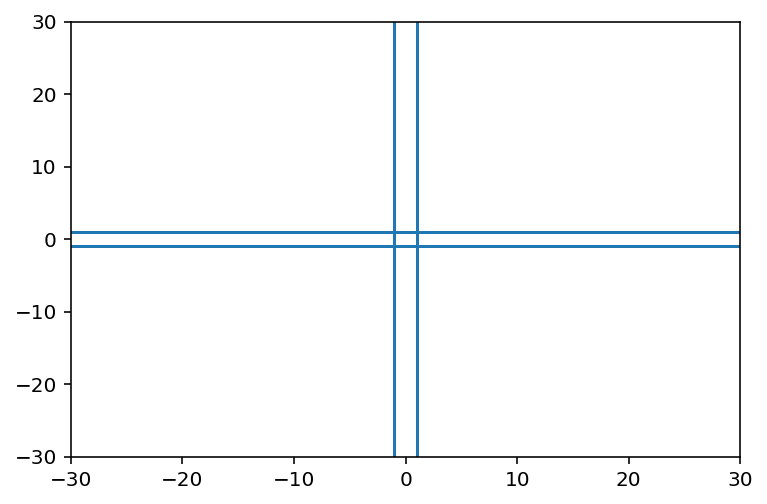

In [38]:
x = np.linspace(-30, 30);
y = np.linspace(-30, 30);

x, y = np.meshgrid(x, y)
position_grid = np.stack((x.ravel(), y.ravel()), axis=1)

n_time = 1

start = multivariate_normal(mean=(0, 0), cov=16).pdf(position_grid)
end = multivariate_normal(mean=(0, 0), cov=16 * n_time).pdf(position_grid)

sigma = np.sqrt(16 * n_time)
# plt.contour(x, y, start.reshape(x_grid.shape))
plt.contour(x, y, end.reshape(x_grid.shape), levels=[sigma, sigma*2, sigma*3])
plt.axhline(n_time)
plt.axhline(-n_time)
plt.axvline(n_time)
plt.axvline(-n_time)